In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('booksummaries.txt', sep='\t',
                 names=['id1', 'id2', 'title', 'author', 'year', 'genres', 'summary'],
                 usecols=[2, 3, 5, 6], converters={'genres' : lambda s : (list(json.loads(s).values()) if s else None)})

In [3]:
valid_genres = ['Science Fiction','Crime Fiction','Non-fiction','Children\'s literature',
                'Fantasy', 'Mystery', 'Suspense', 'Young adult literature']

In [4]:
# Iterate through each row to extract and split the list of genres
book_list = []

# Iterate through each element in the 'genres_column'
for i, row in df.iterrows():
    if row["genres"]:
        for genre in valid_genres:
            new_row={
                "title": row["title"],
                "author": row["author"],
                "summary": row["summary"]
                }
            genre_list=row["genres"]
            if genre in genre_list:
                new_row["genre"]=genre
                book_list.append(new_row)
book_df = pd.DataFrame(book_list)

In [5]:
book_df = book_df.drop_duplicates(subset=['title'])

In [6]:
book_df

,title,author,summary,genre
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",Science Fiction
2,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,Science Fiction
4,A Wizard of Earthsea,Ursula K. Le Guin,"Ged is a young boy on Gont, one of the larger...",Children's literature
6,Blade Runner 3: Replicant Night,K. W. Jeter,"Living on Mars, Deckard is acting as a consul...",Science Fiction
...,...,...,...,...
11369,Heaven,V. C. Andrews,Heaven Leigh Casteel is a fourteen year old g...,Young adult literature
11370,Dark Angel,V. C. Andrews,After the events of Heaven (the first book in...,Young adult literature
11371,Gates of Paradise,V. C. Andrews,"A novel about Annie Stonewall, the daughter o...",Young adult literature
11372,The Third Lynx,Timothy Zahn,The story starts with former government agent...,Science Fiction


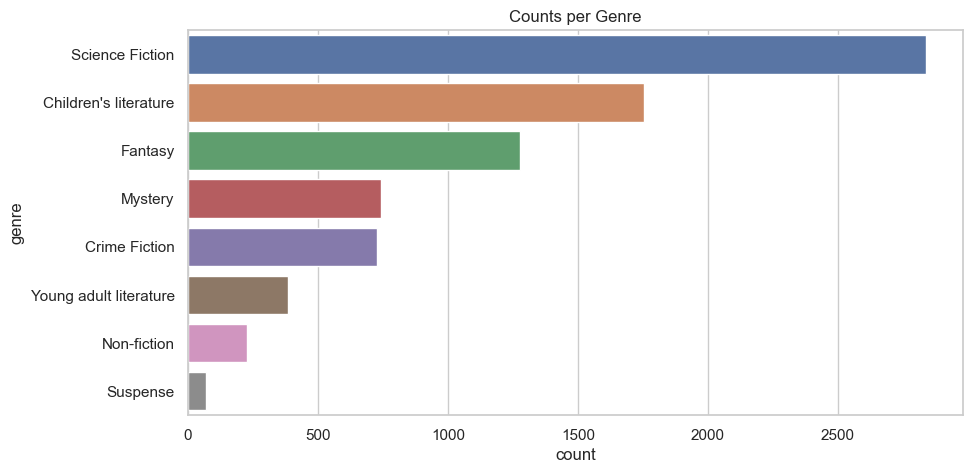

In [7]:
plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid')
sns.countplot(data=book_df, order=book_df["genre"].value_counts().index, y='genre')
plt.title("Counts per Genre")
plt.show()

Text(0.5, 1.0, 'Length distribution')

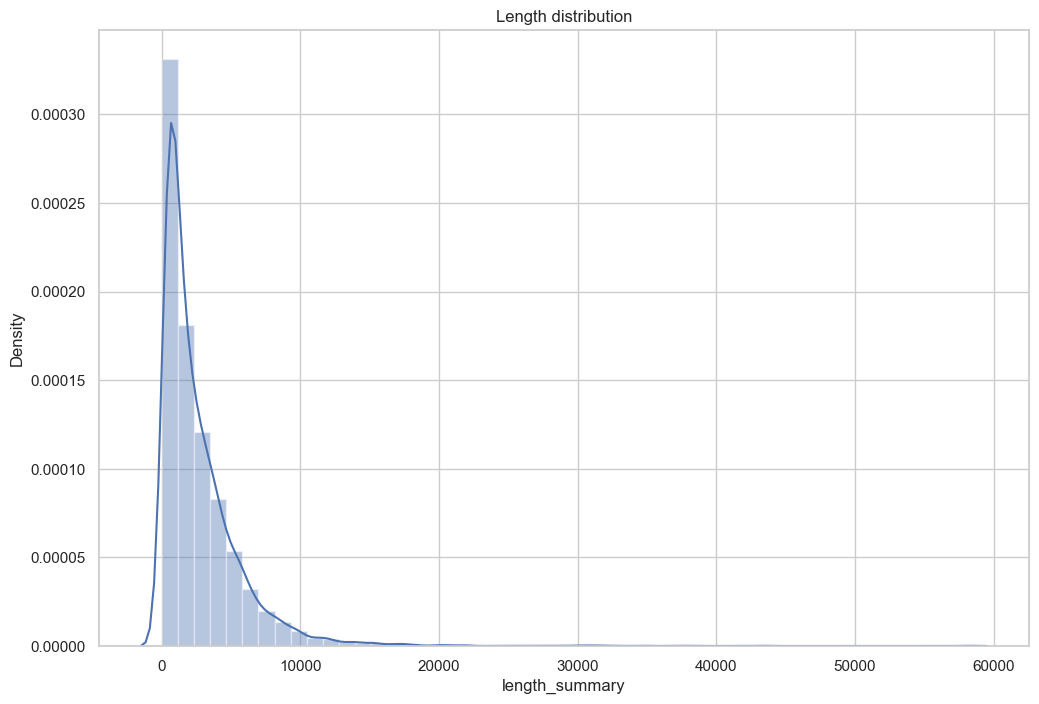

In [8]:
#Calculate posts length
book_df["length_summary"] = book_df["summary"].apply(len)

#Create distribution plot
plt.figure(figsize=(12,8))
sns.distplot(book_df["length_summary"]).set_title("Length distribution")

In [ ]:
book_df.iloc[6]['summary']

In [9]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

#Download stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Perform count vectorization
cv = CountVectorizer(analyzer="word", max_features=2000, strip_accents='ascii', stop_words=stop_words)

X_cnt = cv.fit_transform(book_df['summary'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\navee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Term Frequency Inverse transform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Convert to numpy array
X_cnt.toarray()

#Tfidf object
tfizer = TfidfTransformer()

#Perform Tfid
X_tfidf = tfizer.fit_transform(X_cnt).toarray()

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

book_df['genre_enc'] = encoder.fit_transform(book_df['genre'])

#Get the labels
Y = book_df['genre_enc']

In [14]:
encoder.classes_

array(["Children's literature", 'Crime Fiction', 'Fantasy', 'Mystery',
       'Non-fiction', 'Science Fiction', 'Suspense',
       'Young adult literature'], dtype=object)

In [15]:
from sklearn.model_selection import train_test_split

#Create training / testing data split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=7)

In [16]:
from xgboost import XGBClassifier

#Create the model
xgb_model = XGBClassifier()

In [17]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [18]:
predictions = xgb_model.predict(X_test)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

#Confusion matrix and Classification Report
def perf_eval(y_true, y_pred):
    #Classification report
    print(classification_report(y_true, y_pred,
                                target_names=list(encoder.classes_)))
    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    #Plot the figure
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix,
                cmap='Blues',
                annot=True,
                fmt="d",
                xticklabels=list(encoder.classes_),
                yticklabels=list(encoder.classes_))
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

                        precision    recall  f1-score   support

 Children's literature       0.55      0.68      0.61       349
         Crime Fiction       0.63      0.59      0.61       150
               Fantasy       0.55      0.52      0.54       244
               Mystery       0.48      0.43      0.45       122
           Non-fiction       0.80      0.37      0.51        43
       Science Fiction       0.74      0.82      0.78       595
              Suspense       0.00      0.00      0.00        16
Young adult literature       0.43      0.10      0.17        86

              accuracy                           0.63      1605
             macro avg       0.52      0.44      0.46      1605
          weighted avg       0.62      0.63      0.62      1605



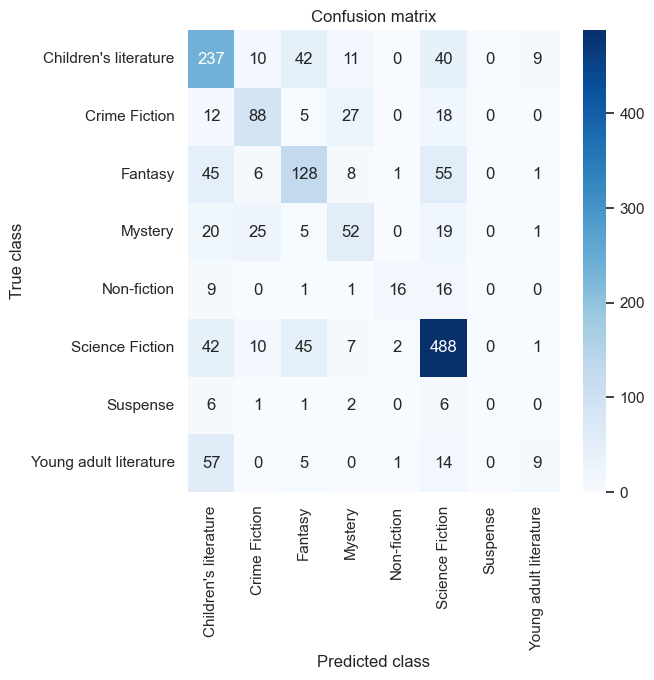

In [20]:
perf_eval(y_test, predictions)